<a href="https://www.kaggle.com/code/macmyller/pdi-project?scriptVersionId=202655973" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [1]:
import os
import torch
import time
import numpy as np
import pandas as pd
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import Counter
from torch.utils.data import Subset
from torchvision import datasets, transforms 
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Utils

In [2]:
# Setting up file paths
train_path = '/kaggle/input/kermany2018/OCT2017 /train'
test_path = '/kaggle/input/kermany2018/OCT2017 /test'
val_path = '/kaggle/input/kermany2018/OCT2017 /val'

In [3]:
categories = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
num_classes = len(categories) 
image_size = (128, 128)
batch_size = 84

# Exploratory Analysis

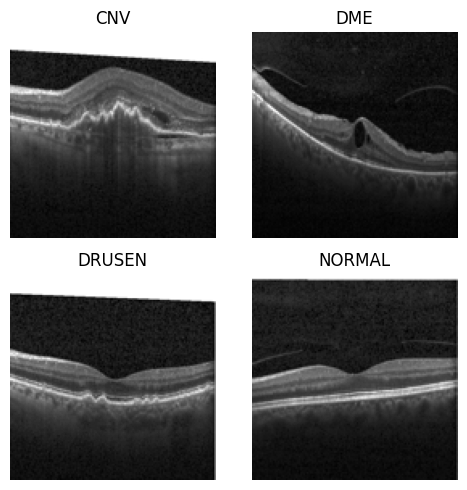

In [4]:
image_files = {
    'CNV': f'{val_path}/CNV/CNV-6294785-1.jpeg',
    'DME': f'{val_path}/DME/DME-9583225-1.jpeg',
    'DRUSEN': f'{val_path}/DRUSEN/DRUSEN-9800172-2.jpeg',
    'NORMAL': f'{val_path}/NORMAL/NORMAL-4872585-1.jpeg'
}

images = {cls: Image.open(img_path).resize(image_size) for cls, img_path in image_files.items()}
fig, axes = plt.subplots(2, 2, figsize=(5, 5))
for ax, (cls, img) in zip(axes.flatten(), images.items()):
    ax.set_title(cls)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.tight_layout() 
plt.show()


In [5]:
# def count_images_in_directory(directory):
#     category_count = {}
#     for category in categories:
#         category_path = os.path.join(directory, category)
#         category_count[category] = len(os.listdir(category_path))
#     return category_count

# train_distribution, test_distribution, val_distribution = \
# %time count_images_in_directory(train_path), count_images_in_directory(test_path), count_images_in_directory(val_path)

In [6]:
# df_distribution = pd.DataFrame({
#     "Train":train_distribution, 
#     "Test":test_distribution, 
#     "Validation":val_distribution
# })

# df_distribution.loc["Total"] = df_distribution.sum(axis=0)
# df_distribution["Total"] = df_distribution.sum(axis=1)

# df_distribution.T

# Load Data (torch)

In [7]:
data_directory = train_path # No artigo, o autor utiliza apenas o diretório de treino para fazer o split em treino, teste e validação

A normalização padrão ajuda a melhorar a convergência durante o treinamento de modelos de aprendizado de máquina, pois evita que a magnitude das variáveis tenha um impacto desproporcional na aprendizagem. Isso é especialmente importante em redes neurais, onde a uniformidade dos dados pode acelerar o treinamento e melhorar a precisão do modelo.

In [8]:
# TODO: verificar se está correto
def get_mean_std_for_standard_transform(dataloader):
    mean, std, total_images, i = 0.0, 0.0, 0, 0
    for images, _ in dataloader:
        print(f"\ri: {i}", end=' ')
        i+=1
        batch_size = images.size(0)
        images = images.view(batch_size, images.size(1), -1)  # (batch_size, channels, num_pixels)
        mean += images.mean(dim=2).sum(dim=0)  # Soma a média do batch
        std += images.std(dim=2).sum(dim=0)    # Soma o desvio padrão do batch
        total_images += batch_size
    mean /= total_images
    std /= total_images
    return mean, std

# get_mean_std_for_standard_transform(train_loader)

In [9]:
# TODO: MODIFICAR PARA USAR AS MESMAS TRANSFORMAÇÕES PRESENTES NO ARTIGO
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.CenterCrop((128, 128)), # TODO: VERIFICAR SE TÁ CORRETO
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.1956, 0.1956, 0.1956], # TODO: VERIFICAR SE TÁ CORRETO
        std  = [0.1890, 0.1890, 0.1890]
    ),
])

# Carregar o dataset
%time dataset = datasets.ImageFolder(root=data_directory, transform=transform)

CPU times: user 628 ms, sys: 814 ms, total: 1.44 s
Wall time: 1min 25s


In [10]:
use_cuda = torch.cuda.is_available()
device = "cuda" if use_cuda else "cpu"
device

'cuda'

Reproduzir datasets com a mesma distribuição entre as classes do artigo (consequentemente a mesma proporção)

In [11]:
def split_dataset_by_class(dataset, desired_counts):
    class_indices = {i: [] for i in range(len(dataset.classes))}
    for idx, label in enumerate(dataset.targets):
        class_indices[label].append(idx)
    train_indices, test_indices, val_indices = [], [], []
    for cls in range(len(dataset.classes)):
        train_size = min(desired_counts['train'][cls], len(class_indices[cls]))
        train_indices.extend(class_indices[cls][:train_size])
        test_size = min(desired_counts['test'][cls], len(class_indices[cls]) - train_size)
        test_indices.extend(class_indices[cls][train_size:train_size + test_size])
        val_size = min(desired_counts['val'][cls], len(class_indices[cls]) - train_size - test_size)
        val_indices.extend(class_indices[cls][train_size + test_size:train_size + test_size + val_size])
    train_dataset = Subset(dataset, train_indices)
    test_dataset = Subset(dataset, test_indices)
    val_dataset = Subset(dataset, val_indices)
    return train_dataset, test_dataset, val_dataset


def get_desired_counts(scale=1):
    base_counts = { # classes 0, 1, 2, 3 / 'CNV', 'DME', 'DRUSEN', 'NORMAL'
        'train': [33509, 10197, 7753, 23811],  
        'test':  [2951, 936, 693, 2098],       
        'val':   [745, 215, 170, 406]          
    }
    return {key: [count // scale for count in value] for key, value in base_counts.items()}

In [12]:
desired_counts = {}
if use_cuda:
    desired_counts = get_desired_counts()  # Usa os valores originais
else:
    desired_counts = get_desired_counts(scale=10)  # Usa 1//scale dos valores
train_dataset, test_dataset, val_dataset = split_dataset_by_class(dataset, desired_counts)
print(len(train_dataset), len(test_dataset), len(val_dataset))
print(desired_counts)

75270 6678 1536
{'train': [33509, 10197, 7753, 23811], 'test': [2951, 936, 693, 2098], 'val': [745, 215, 170, 406]}


In [13]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
# CALCULAR A MEDIA E DESVIO DO TRAIN_lOADER

In [15]:
# print("Train distribution")
# %time train_dataset_distribution = Counter(categories[label] for _, label in train_dataset)
# print("Test distribution")
# %time test_dataset_distribution = Counter(categories[label] for _, label in test_dataset)
# print("Val distribution")
# %time val_dataset_distribution = Counter(categories[label] for _, label in val_dataset)

In [16]:
# data = {
#     'Training': train_dataset_distribution, 
#     'Testing': test_dataset_distribution, 
#     'Validation': val_dataset_distribution, 
# }

# df_distribution = pd.DataFrame(data)
# df_distribution.loc["Total"] = df_distribution.sum()
# df_distribution["Total"] = df_distribution.sum(axis=1)
# df_distribution[["Total", "Training", "Testing", "Validation"]].T

# Preprocessing

Etapas para pré-processamento de dados:

1.
Leia arquivos do diretório.

2.
Aplique o redimensionamento de cada imagem para 150 × 150 pixels.

3.
Aplique a operação CentreCrop com dimensões finais de 128 × 128 pixels a cada imagem.

4.
Converta a imagem para o tipo de dados tensor para compatibilidade com o modelo.

5.
Normalize a imagem subtraindo a média de cada valor de pixel e dividindo o resultado pelo desvio padrão usando a transformação padrão.



In [17]:
# TODO: PREPROCESSAR AS IMAGENS

Etapas para aprimoramento de imagem:

1.
Leia arquivos do diretório.

2.
Aplique filtro de desfoque médio para suavizar.

3.
Converta para escala de cinza para operações futuras.

4.
Aplique CLAHE sobre a imagem para melhorar o contraste baixo.

5.
Limiar de imagem por limites de corte de limiar adequados.

6.
Remova ruídos e quebras adicionais na estrutura por meio de operação de morfologia.

7.
Extraia contornos da saída acima para extrair bordas da camada da retina (as outras técnicas de detecção de bordas não foram úteis, conforme discutido).

8.
Desenhe contornos na imagem original para permitir bordas e estruturas de camadas.

9.
Aplique outras transformações como na etapa anterior, incluindo redimensionamento, corte central e normalização.



In [18]:
# TODO: APRIMORAR AS IMAGENS

# Convolutional Neural Network Architectures

In [19]:
def train(model, train_loader, epochs=10):
    model.train()  # Colocar o modelo em modo de treino
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Zerar gradientes
            outputs = model(inputs)  # Forward pass
            loss = criterion(F.log_softmax(outputs, dim=1), labels)  # Calcular a perda
            loss.backward()  # Backward pass
            optimizer.step()  # Atualizar pesos
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)  # Cálculo da perda média


def eval(model, test_loader):
    model.eval()  # Coloca o modelo em modo de avaliação
    all_preds, all_labels = [], []
    with torch.no_grad():  # Desabilitar o cálculo de gradiente para economizar memória
        for inputs, labels in tqdm(test_loader, desc="Test Progress", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)   
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy()) 
    return all_preds, all_labels


def get_confusion_matrix(all_labels, all_preds, figsize=(10, 8), class_names = dataset.classes):
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=figsize)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.title('Confusion Matrix')
    plt.show()


def evaluate_model(all_labels, all_preds):
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1) 
    return accuracy, precision, recall, f1

## Architectures used in the article (torch)

In [20]:
class CNN_Network(nn.Module): # Minha rede 
    def __init__(self):
        super(CNN_Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 1))
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1))
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=(1, 1))
        self.conv5 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=(1, 1))
        # Calcular o tamanho da saída da última camada convolucional
        self._to_linear = None
        self._initialize_weights()

    def _initialize_weights(self):
        # Cria uma entrada fictícia para calcular o tamanho da saída da camada convolucional
        x = torch.randn(1, 3, 128, 128)  # Um exemplo com batch size 1
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        self._to_linear = x.numel()  # Número total de elementos na saída
        # Definir as camadas totalmente conectadas
        self.fc1 = nn.Linear(self._to_linear, 1536)
        self.fc2 = nn.Linear(1536, 512)
        self.fc3 = nn.Linear(512, 4)
        # TODO: FALTA A CAMADA DE DROPOUT 40%
        # TODO: FALTA A CAMADA DE LOG-SOFTMAX
        # OUTPUT: LOG-SOFTMAX PROBABILITY (4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(x.size(0), -1)  # Achatar o tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # Saída logits

In [21]:
class CNN5(nn.Module):
    def __init__(self):
        super(CNN5, self).__init__()
        # Camada convolucional 1 (Entrada: 128x128x3, Saída: 128x128x16)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)  # 3 canais de entrada (RGB)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduz a dimensão pela metade
        # Camada convolucional 2 (Entrada: 64x64x16, Saída: 64x64x32)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # Camada convolucional 3-1 (Entrada: 32x32x32, Saída: 32x32x32)
        self.conv3_1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        # Camada convolucional 3-2 (Entrada: 32x32x32, Saída: 32x32x48)
        self.conv3_2 = nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, padding=1)
        # Camada convolucional 4-1 (Entrada: 16x16x48, Saída: 16x16x48)
        self.conv4 = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, padding=1)
        # Dropout para regularização
        self.dropout = nn.Dropout(p=0.4)
        # Fully connected layers (dense)
        # Linear camada após o flatten da saída convolucional
        self.fc1 = nn.Linear(48 * 8 * 8, 1536)  # A entrada da camada linear depende da saída da última conv/pooling
        self.fc2 = nn.Linear(1536, 512)
        self.fc3 = nn.Linear(512, 4)  # Saída final para 4 classes
        
    def forward(self, x):
        # Camada 1 - Conv1 + MaxPool
        x = self.pool(F.relu(self.conv1(x)))  # (128x128x16 -> 64x64x16)
        # Camada 2 - Conv2 + MaxPool
        x = self.pool(F.relu(self.conv2(x)))  # (64x64x32 -> 32x32x32)
        # Camada 3 - Conv3-1 + Conv3-2 + MaxPool
        x = F.relu(self.conv3_1(x))           # (32x32x32 -> 32x32x32)
        x = self.pool(F.relu(self.conv3_2(x)))  # (32x32x48 -> 16x16x48)
        # Camada 4 - Conv4-1 + MaxPool
        x = self.pool(F.relu(self.conv4(x)))  # (16x16x48 -> 8x8x48)
        # Flatten (achatar) os dados para a camada totalmente conectada (dense)
        x = x.view(-1, 48 * 8 * 8)  # (batch_size, 48*8*8)
        # Fully connected layers
        x = F.relu(self.fc1(x))  # (48*8*8 -> 1536)
        x = F.relu(self.fc2(x))  # (1536 -> 512)
        # Aplicar dropout
        x = self.dropout(x)
        # Camada de saída - Log-Softmax
        x = F.log_softmax(self.fc3(x), dim=1)  # (512 -> 4)
        return x

In [22]:
# Hiperparâmetros
learning_rate = 0.001
epochs = 10 if use_cuda else 3 

CNN_Network

In [23]:
# Instanciando o modelo, critério de perda e otimizador
model_1 = CNN_Network().to(device) 
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_1.parameters(), lr=learning_rate)
# model_1 # mostrar a arquitetura do modelo

In [24]:
# TODO: armazenar o history de treinamento (acc, loss)
train(model_1, train_loader, epochs)

In [25]:
all_preds, all_labels = eval(model_1, test_loader)

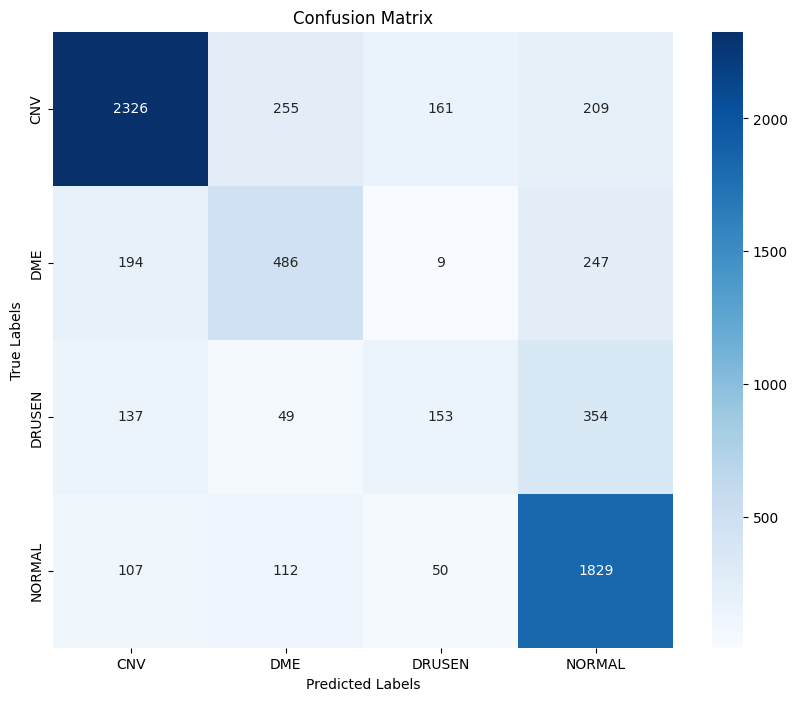

In [26]:
get_confusion_matrix(all_labels, all_preds)

CNN5

In [27]:
# Instanciando o modelo, critério de perda e otimizador
model_2 = CNN5().to(device) 
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_2.parameters(), lr=learning_rate)
# model_2 # mostrar a arquitetura do modelo

In [28]:
train(model_2, train_loader, epochs)

In [29]:
all_preds, all_labels = eval(model_2, test_loader)

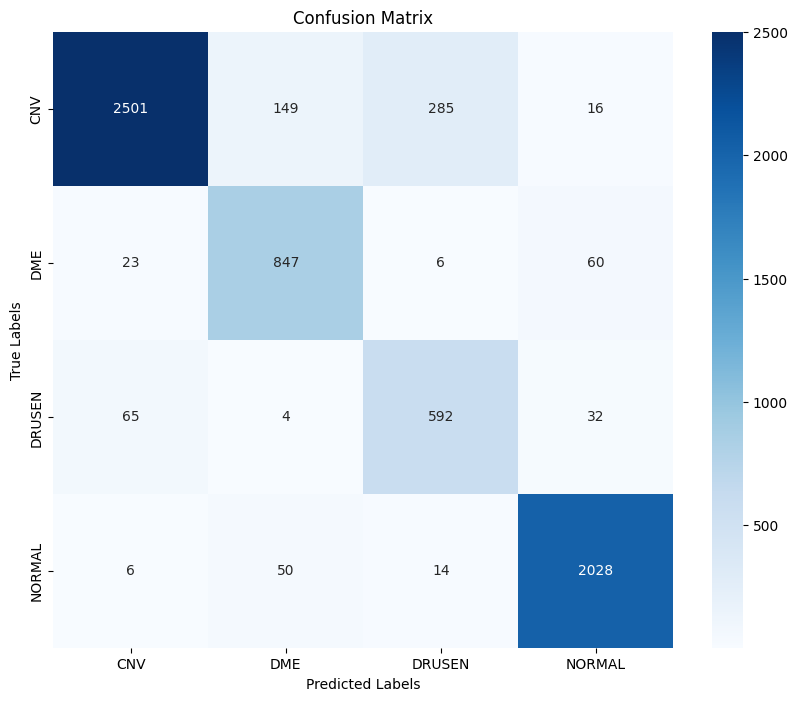

In [30]:
get_confusion_matrix(all_labels, all_preds)